# Read in data

In [56]:
import numpy.linalg as la
import xarray as xr
import numpy as np

def get_anomaly(x):
    """Remove the seasonal cycle from the data.
    Params: x (numpy array): data with time dimension
    Returns: x (numpy array): data with seasonal cycle removed
    """
    nt, ny, nx = x.shape
    x = x.reshape(nt//12, 12, ny, nx)
    # seasonal mean
    x_mean = x.mean(axis=0, keepdims=True)
    # remove seasonal cycle
    x = x - x_mean
    # reshape time dimension
    x = x.reshape(nt, ny, nx)
    return x

def running_mean(x, m):
    """Compute the running mean of x along the first dimension.
    Params: x (numpy array): data
            m (int): half of the window size
    Returns: x (numpy array): data with running mean
    """
    # reference:
    # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    nt, ns = x.shape
    x_rm = np.zeros_like(x)
    # pad the data along the dimension dim with m elements
    pad_width = [(0, 0)]*x.ndim
    pad_width[0] = (m, m)
    x = np.pad(x, pad_width, mode='edge')
    # compute the running mean
    for i in range(ns):
        x_rm[:,i] = np.convolve(x[:,i], np.ones(2*m+1)/float(2*m+1), mode='valid')
    return x_rm

# read in the data
dir = "../NCEP_monthly_mean_data/"
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
sst_da, grid_da = sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max))
lat, lon = sst.lat.values, sst.lon.values
time = sst.time.values
# get the data as numpy arrays
sst, grid = sst.values, grid.values
grid = grid[0,:,:]
# get dimensions
nt, ny, nx = sst.shape
# standard deviation
sst_std = sst.std()
# normalize the data
sst_anom = get_anomaly(sst)
# mask out the land
sst_anom[:, grid == -1] = 0
# reshape vars to space x time
sst = sst_anom.reshape(nt, ny*nx)
# get 3-month running mean with a window size of 3 (half window size is 1)
sst = running_mean(sst, 1)
sst = sst.reshape(nt, ny, nx)
print(sst.shape)

(624, 32, 107)


# EOF decomposition and reconstruction
Decomposite SST using EOF (empirical orthogonal functions), and reconstruct the SST field using the first leading $m$ modes.

In [57]:
# reference: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
from eofs.standard import Eof
# compute the first 10 EOFs
# weights = np.cos(np.deg2rad(lat))[np.newaxis,:,np.newaxis]
# solver = Eof(sst, weights=weights)
solver = Eof(sst)
eofs = solver.eofsAsCovariance(neofs=10)
pcs = solver.pcs(npcs=10, pcscaling=1)
print(eofs.shape, pcs.shape)

(10, 32, 107) (624, 10)


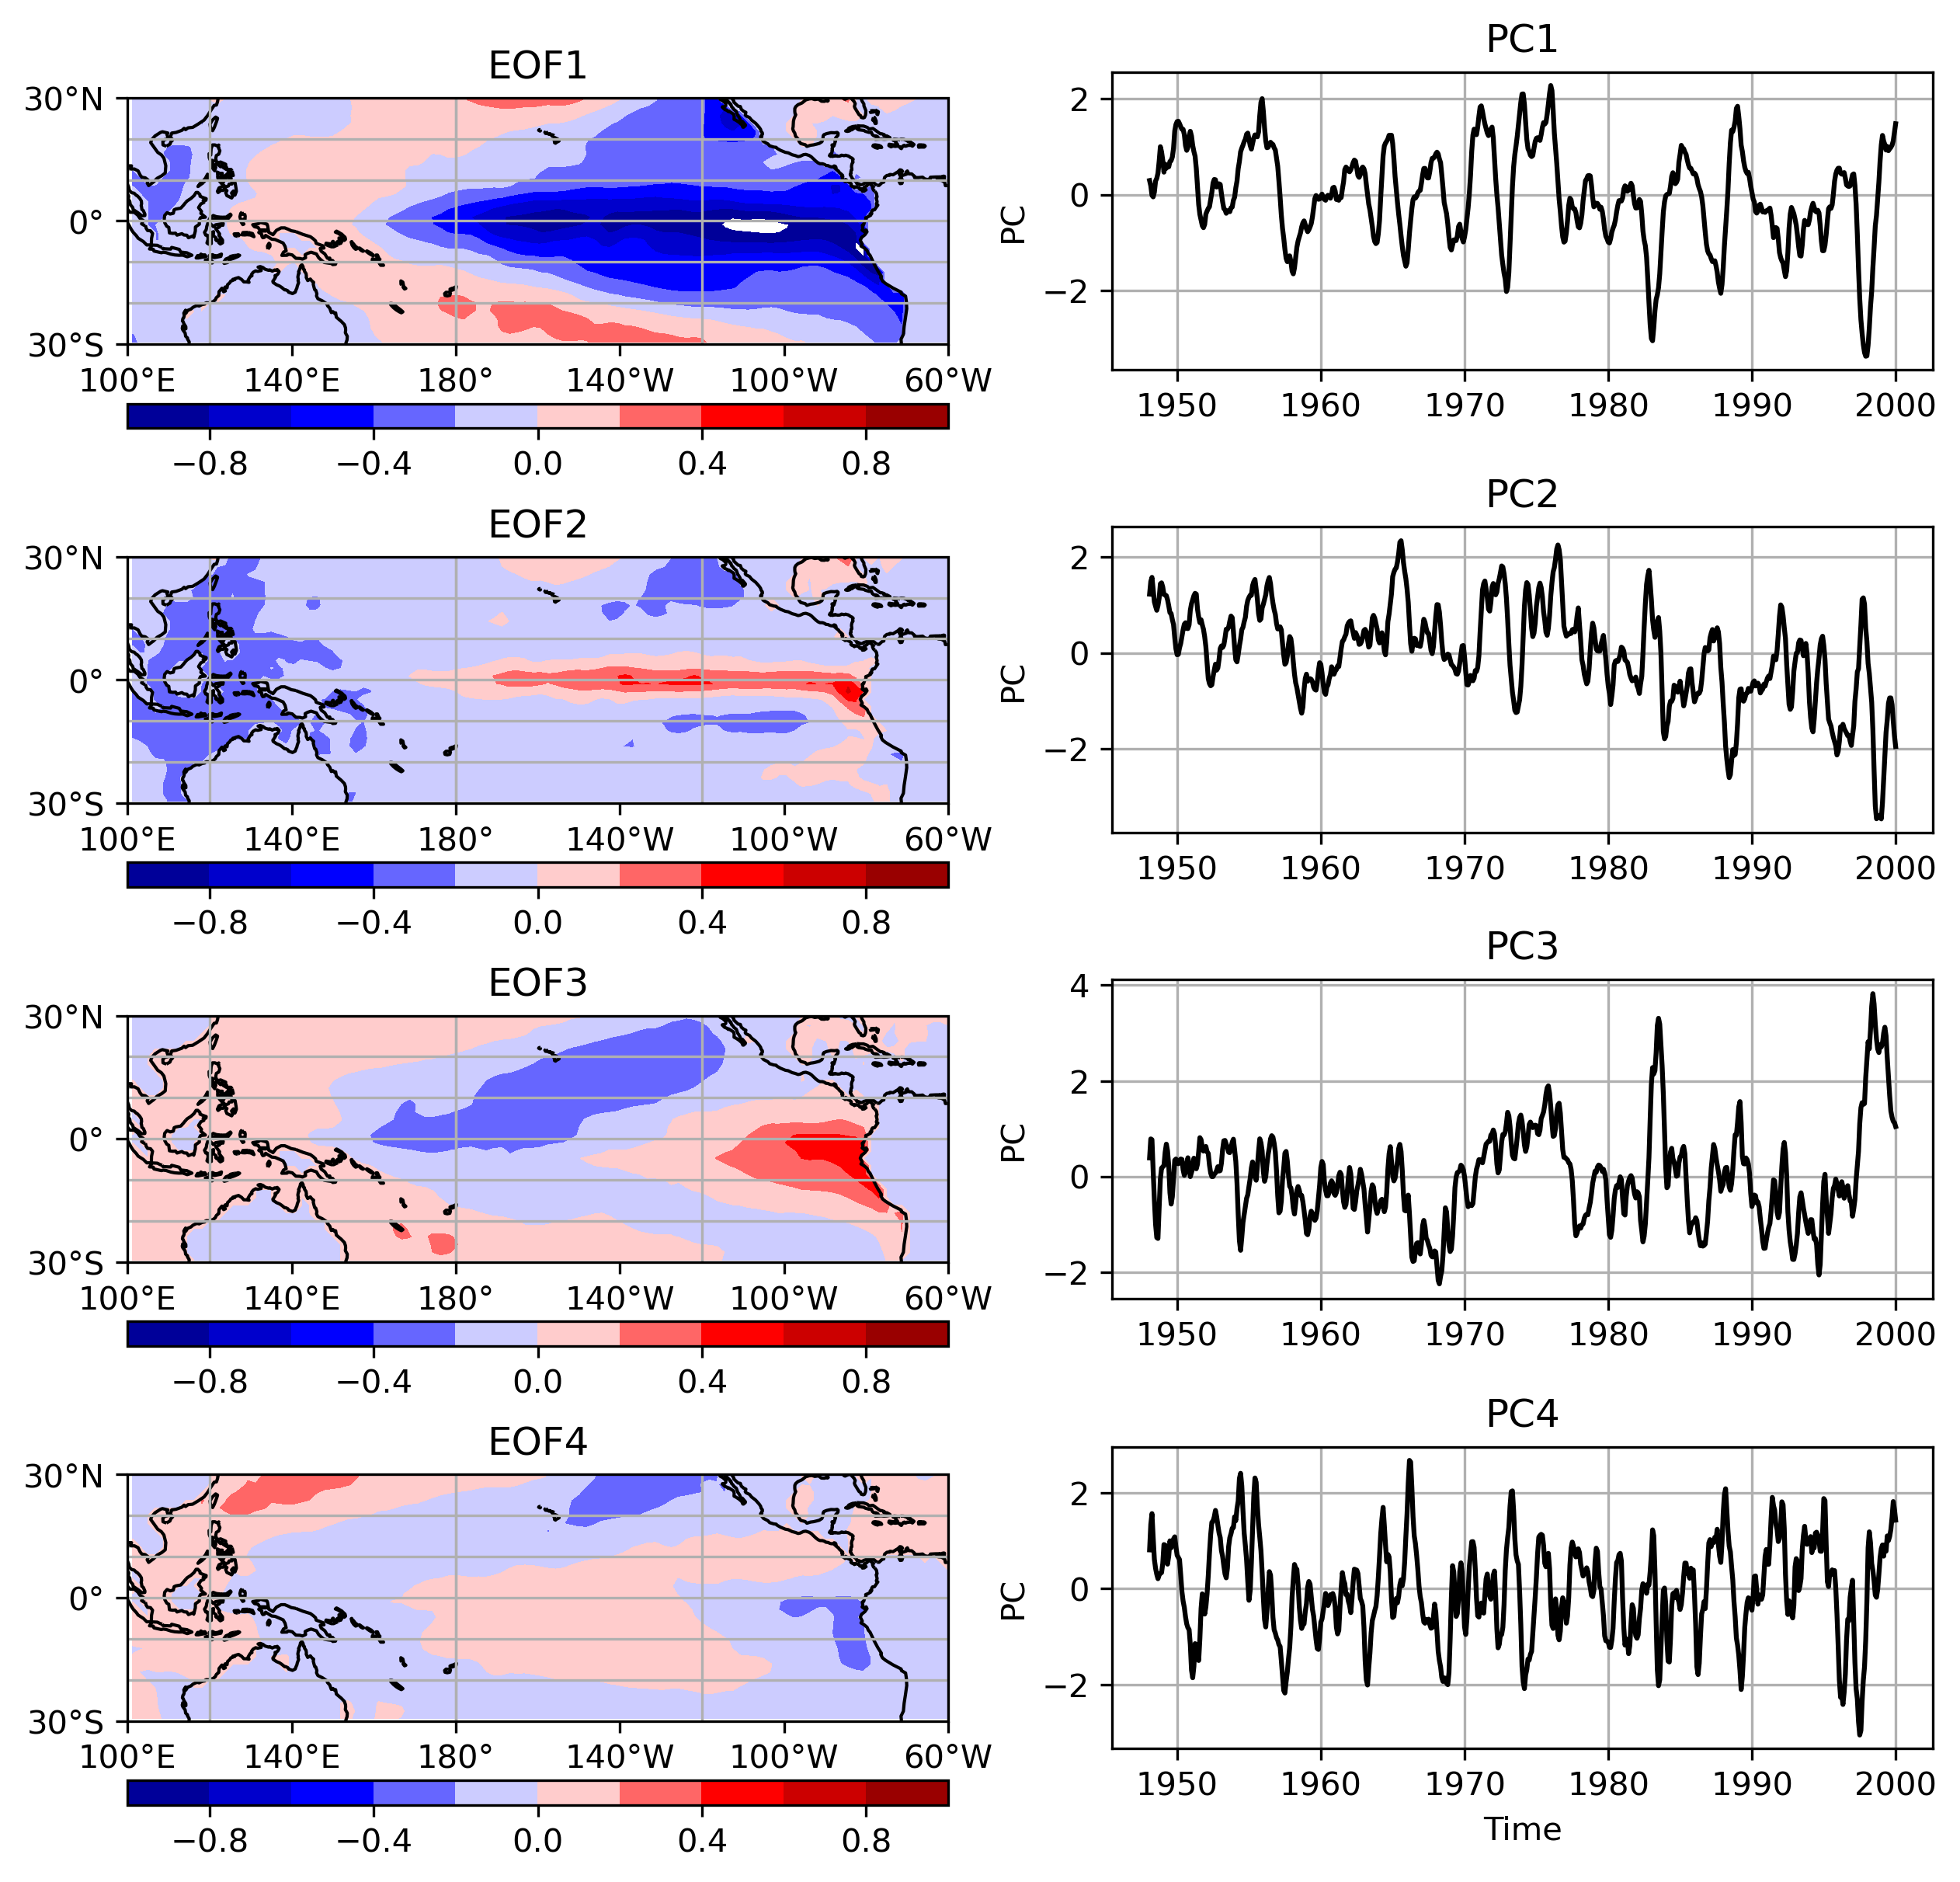

In [58]:
# plot the first 3 EOFs

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# set up the figure, left column for EOFs, right column for PCs
plot_modes = 4
fig = plt.figure(figsize=(10, 10), dpi=300)
# set up the projection
projection = ccrs.PlateCarree(central_longitude=180)
# set up the axes
axes = np.empty((plot_modes, 2), dtype=object)
for i in range(plot_modes):
    axes[i,0] = fig.add_subplot(plot_modes, 2, 2*i+1, projection=projection)
    axes[i,1] = fig.add_subplot(plot_modes, 2, 2*i+2)
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the first 4 EOFs
for i in range(plot_modes):
    ax = axes[i,0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # plot the EOF
    im = ax.contourf(lon, lat, eofs[i,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
    # add coastlines
    ax.coastlines()
    # add gridlines
    ax.gridlines()
    # add title
    ax.set_title("EOF" + str(i+1))
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
    fig.colorbar(im, cax=cax, orientation='horizontal')
    aspect_ratio = 1/ax.get_data_ratio()
    # plot the PC
    ax = axes[i,1]
    # set aspect ratio
    ax.set_aspect(aspect_ratio*ax.get_data_ratio())
    ax.plot(time_fl, pcs[:,i], color='k')
    ax.set_title("PC" + str(i+1))
    if i == plot_modes-1:
        ax.set_xlabel("Time")
    ax.set_ylabel("PC")
    # add gridlines
    ax.grid()
# plt.tight_layout()
# show and save the figure
plt.show()
fig.savefig("EOFs_PCs.png", dpi=300, bbox_inches='tight')

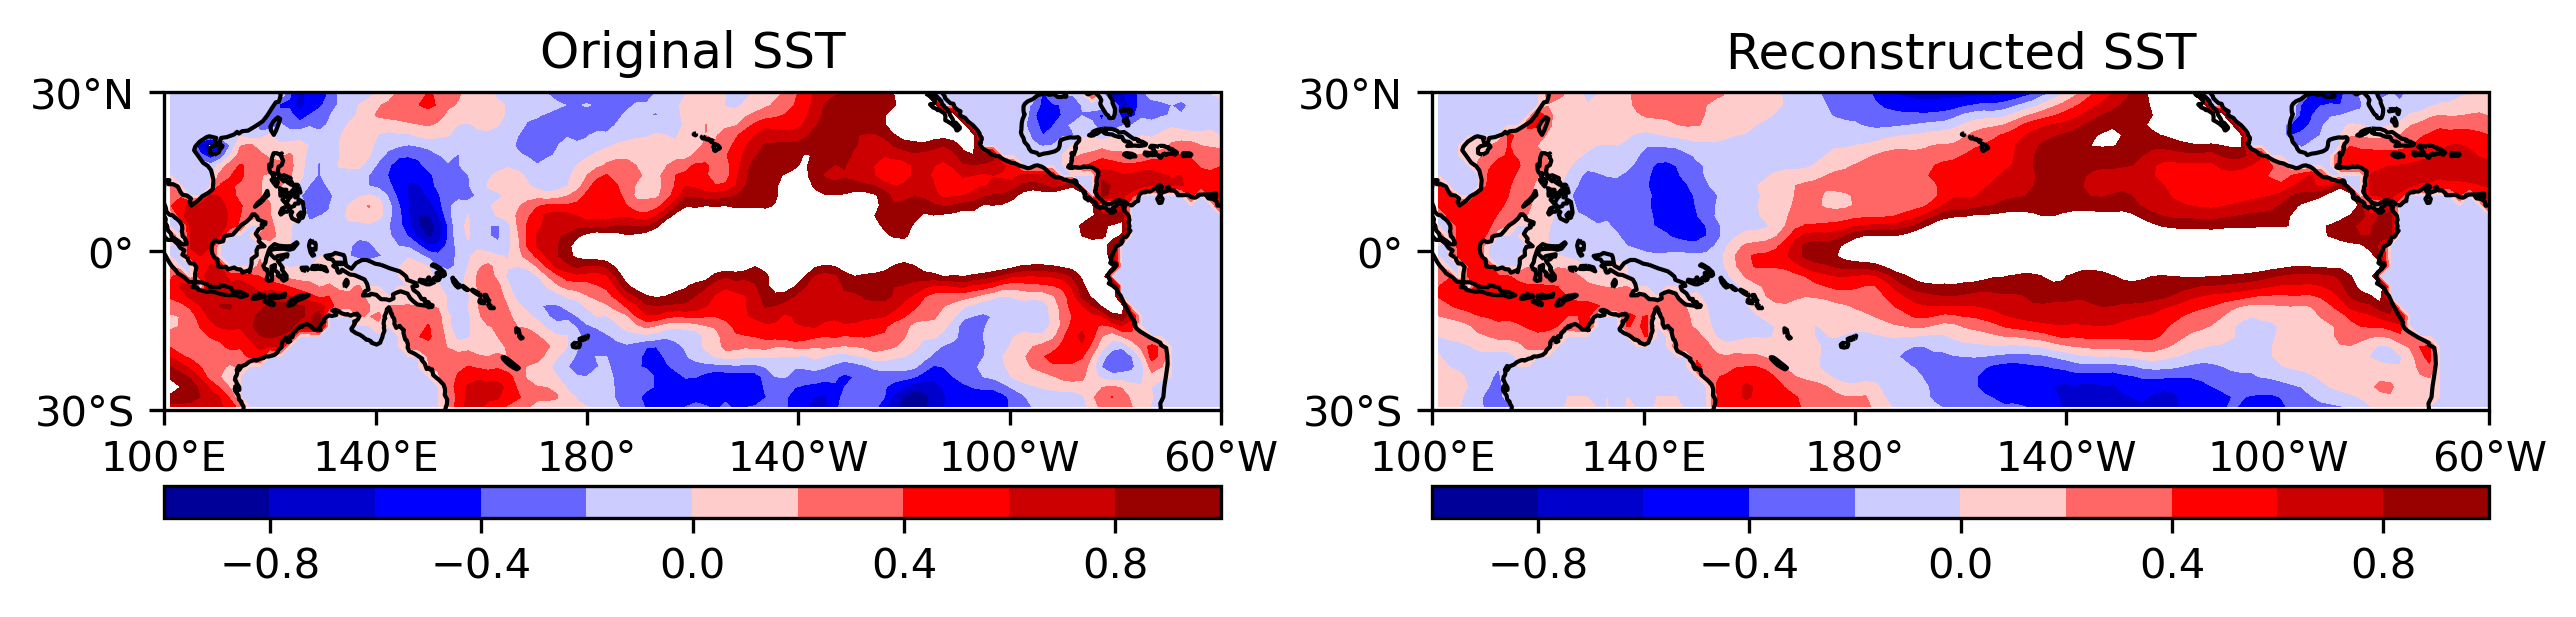

In [63]:
# reconstruct the first m EOFs
m = 10
sst_recon = solver.reconstructedField(m)

# plot the reconstructed SST and the original SST
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                            subplot_kw={'projection': projection},
                            dpi=300)

# plot the reconstructed SST at the first time step
for i in range(2):
    ax = axes[i]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    if i == 0:
        im = ax.contourf(lon, lat, sst[120,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
        ax.set_title("Original SST")
    else:
        im = ax.contourf(lon, lat, sst_recon[120,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
        ax.set_title("Reconstructed SST")
    # add coastlines
    ax.coastlines()
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
    fig.colorbar(im, cax=cax, orientation='horizontal')

# plt.tight_layout()
plt.show()
fig.savefig("recon.png", dpi=300, bbox_inches='tight')
